- model : alexnet
- trans : transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
- optim : Adam(alexnet(pretrained=True).classifier.parameters(), lr = 0.001)
- lr_scheduler : StepLR(optim, step_size=7, gamma=0.1)

In [1]:
from glob import glob
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import joblib
import time, copy

# Model
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary
from torchvision.models import alexnet

# 성능 평가
from sklearn.metrics import f1_score

# 시각화
import matplotlib.pyplot as plt

In [5]:
trans = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.465, 0.406), (0.229, 0.224,0.225))])

In [6]:
train_set = torchvision.datasets.ImageFolder(root = './ML/Train_faabad06fe/Train',
                                             transform = trans)
val_set = torchvision.datasets.ImageFolder(root = './ML/Validation_9857834a3b',
                                           transform = trans)

In [7]:
print(train_set.classes)
print(val_set.classes)

['ILD', 'Lung_Cancer', 'Normal', 'pneumonia', 'pneumothorax']
['ILD', 'Lung_Cancer', 'Normal', 'pneumonia', 'pneumothorax']


In [8]:
image_set = {'train' : train_set, 'val' : val_set}
image_loaders = {x: DataLoader(image_set[x], batch_size=32, shuffle=True, num_workers=0)
                 for x in ['train', 'val']}
dataset_sizes = {x: len(image_set[x]) for x in ['train', 'val']}
class_names = image_set['train'].classes

In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [10]:
device

device(type='cuda', index=0)

In [22]:
# 성능 시각화를 위한 losses, flscores 변수 선언.
losses = {'train':[], 'val':[]}
flscores = {'train':[], 'val':[]}

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1score = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)마다 train과 val 단계 진행.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정.
            else:
                model.eval()   # 모델을 평가 모드로 설정.

            running_loss = 0.0
            running_f1score = []

            # 데이터를 반복.
            for inputs, labels in image_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정.
                optimizer.zero_grad()
                
                # 학습.
                if phase == 'train':
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, dim=1)
                        #_, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        f1score = f1_score(labels.data.cpu(), preds.data.cpu(), average = 'macro')

                        # 역전파 + 최적화 진행.
                        loss.requires_grad_(True)
                        loss.backward()
                        optimizer.step()
                
                # 평가.
                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, dim=1)
                        #_, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        f1score = f1_score(labels.data.cpu(), preds.data.cpu(), average = 'macro')
                        
                # 통계.
                running_loss += loss.item() * inputs.size(0)
                running_f1score.append(f1score)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1score = sum(running_f1score) / len(running_f1score)
            
            losses[phase].append(epoch_loss)
            flscores[phase].append(epoch_f1score)
            
            print(f'{phase} Loss: {epoch_loss:.4f} F1-Score: {epoch_f1score:.4f}')

            # 모델 deep copy.
            if phase == 'val' and epoch_f1score > best_f1score:
                best_f1score = epoch_f1score
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1-Score: {best_f1score:4f}')

    # 가장 나은 모델 가중치를 불러옴.
    model.load_state_dict(best_model_wts)
    return model

In [26]:
model_conv = alexnet(pretrained=True).to(device)

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

#optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [27]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.6766 F1-Score: 0.6152
val Loss: 0.5260 F1-Score: 0.6229

Epoch 1/14
----------
train Loss: 0.5601 F1-Score: 0.6813
val Loss: 0.4462 F1-Score: 0.7175

Epoch 2/14
----------
train Loss: 0.5588 F1-Score: 0.6951
val Loss: 0.3998 F1-Score: 0.7490

Epoch 3/14
----------
train Loss: 0.5236 F1-Score: 0.7004
val Loss: 0.4160 F1-Score: 0.7165

Epoch 4/14
----------
train Loss: 0.5236 F1-Score: 0.7047
val Loss: 0.4984 F1-Score: 0.6704

Epoch 5/14
----------
train Loss: 0.5237 F1-Score: 0.7130
val Loss: 0.4178 F1-Score: 0.7209

Epoch 6/14
----------
train Loss: 0.5100 F1-Score: 0.7231
val Loss: 0.3398 F1-Score: 0.7886

Epoch 7/14
----------
train Loss: 0.4633 F1-Score: 0.7484
val Loss: 0.4065 F1-Score: 0.7530

Epoch 8/14
----------
train Loss: 0.4729 F1-Score: 0.7419
val Loss: 0.3993 F1-Score: 0.7406

Epoch 9/14
----------
train Loss: 0.4637 F1-Score: 0.7412
val Loss: 0.4052 F1-Score: 0.7311

Epoch 10/14
----------
train Loss: 0.4648 F1-Score: 0.7383
val Loss: 0

In [38]:
torch.save(model_conv, 'AlexNetAdamSave.pt')

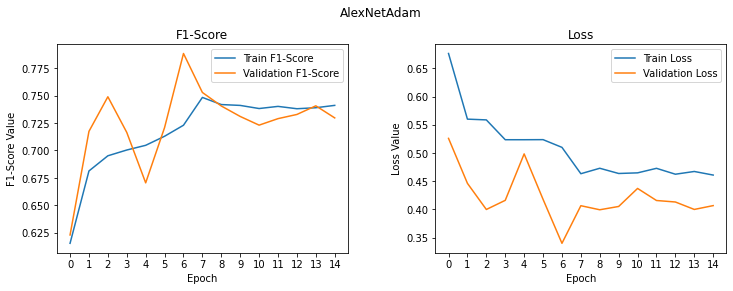

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('AlexNetAdam', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = 15 #에폭사이즈
ax1.plot(range(epochs), flscores['train'], label='Train F1-Score')
ax1.plot(range(epochs), flscores['val'], label='Validation F1-Score')
ax1.set_xticks(np.arange(0, epochs))
ax1.set_ylabel('F1-Score Value')
ax1.set_xlabel('Epoch')
ax1.set_title('F1-Score')
l1 = ax1.legend(loc="best")

ax2.plot(range(epochs), losses['train'], label='Train Loss')
ax2.plot(range(epochs), losses['val'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [40]:
f.savefig('alexnetadam_plt', dpi = 300)